In [1]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch

from tqdm import tqdm

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
pyro.set_rng_seed(0)

# From the doc

## 'Regular' GP

In [4]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

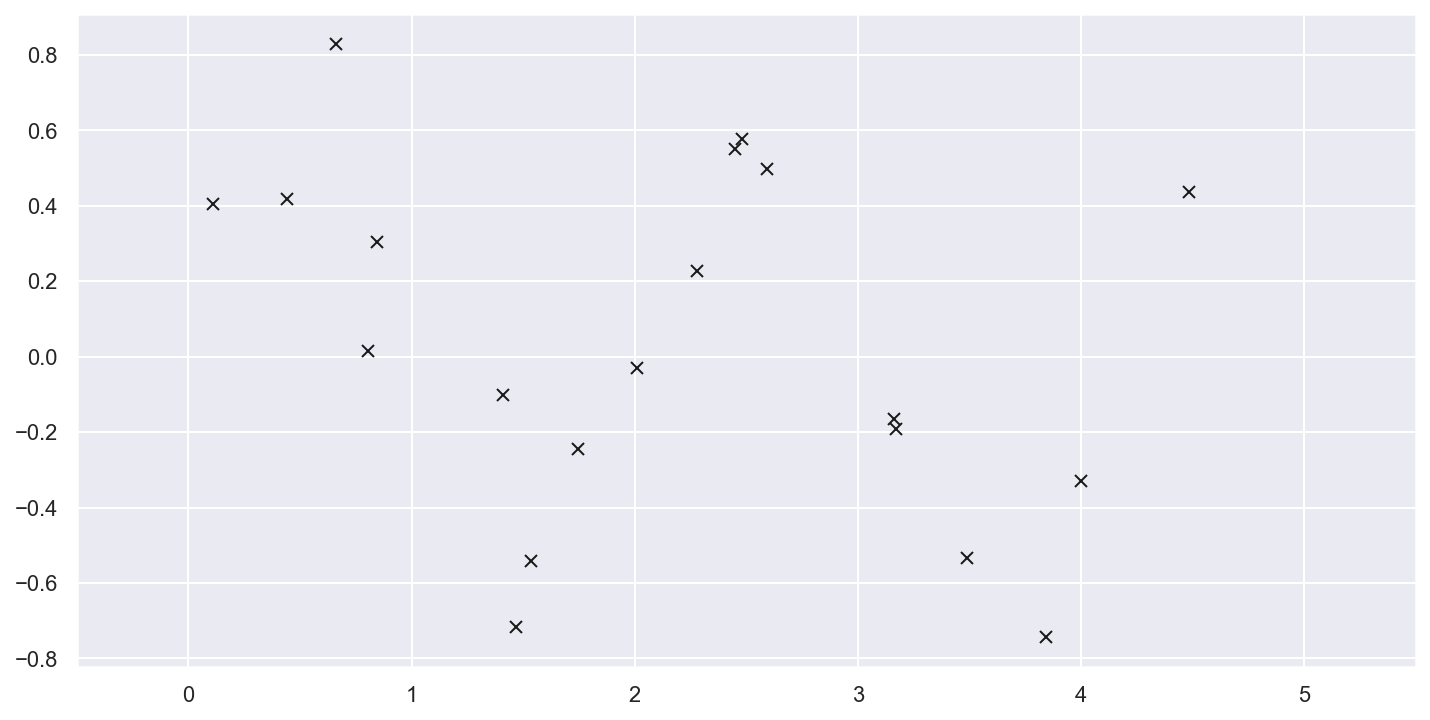

In [5]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [6]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

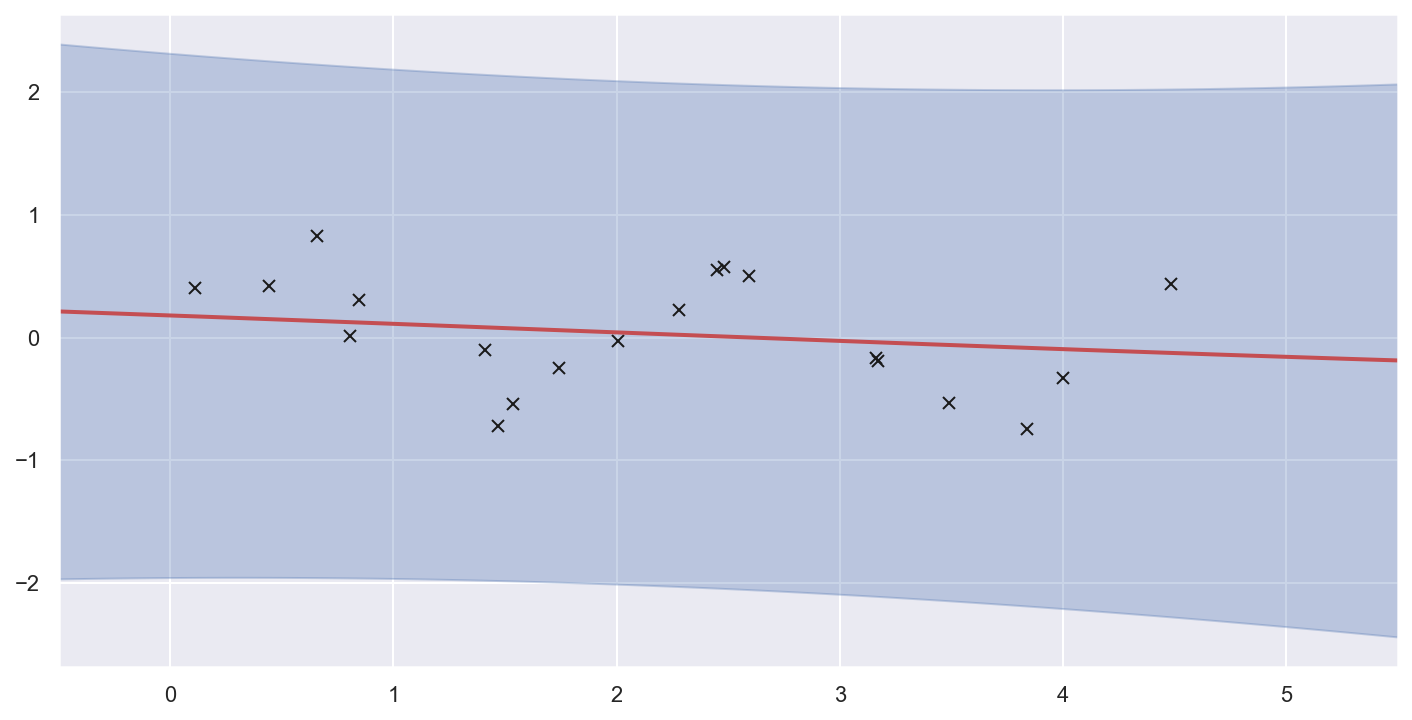

In [7]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True);

In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500

for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 2500/2500 [00:05<00:00, 466.65it/s]


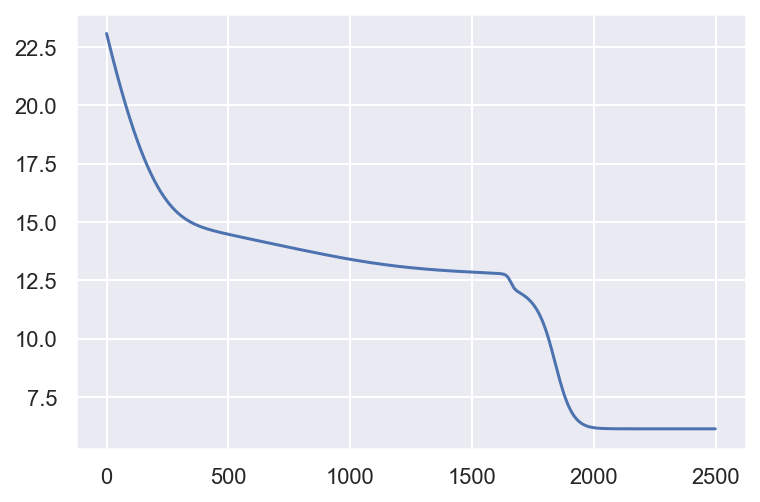

In [9]:
# let's plot the loss curve after 2500 steps of training
plt.plot(losses);

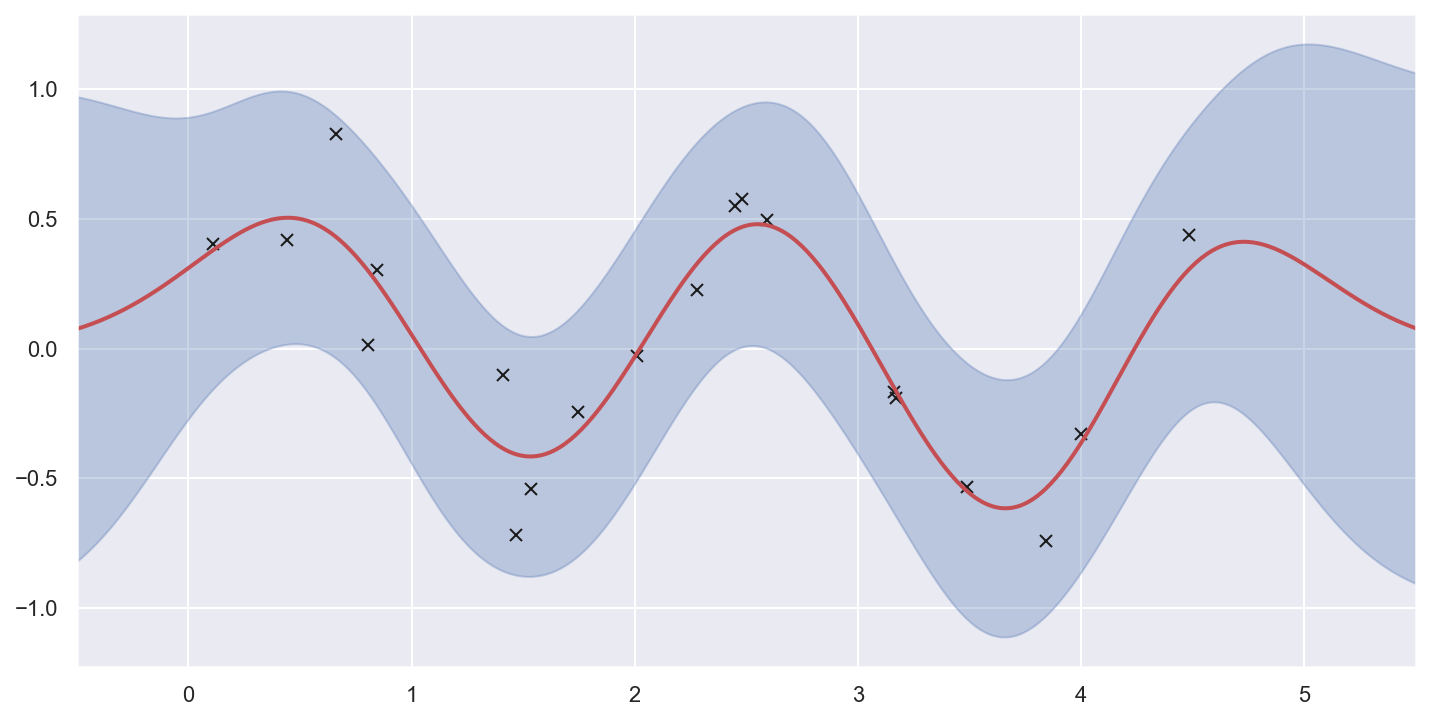

In [10]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True);

## Sparse regression

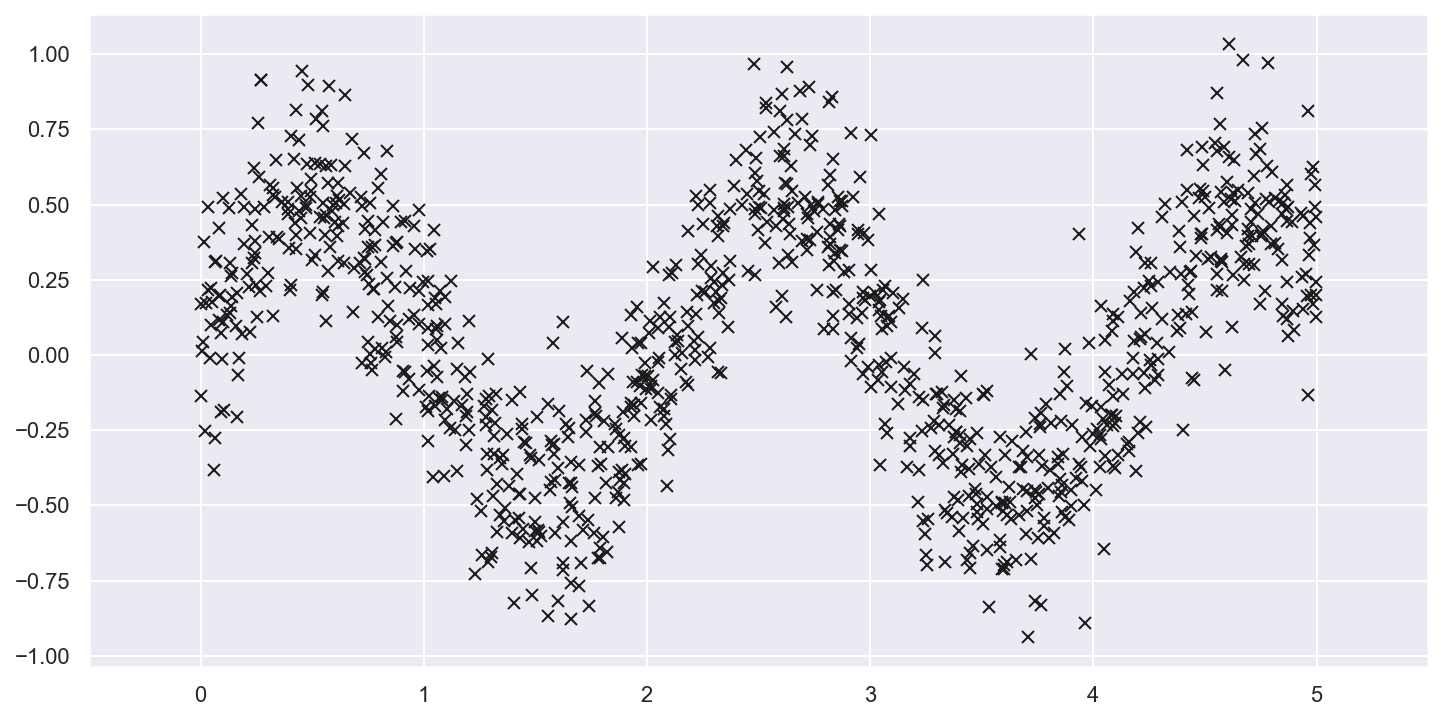

In [11]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

100%|██████████| 2500/2500 [00:12<00:00, 205.78it/s]


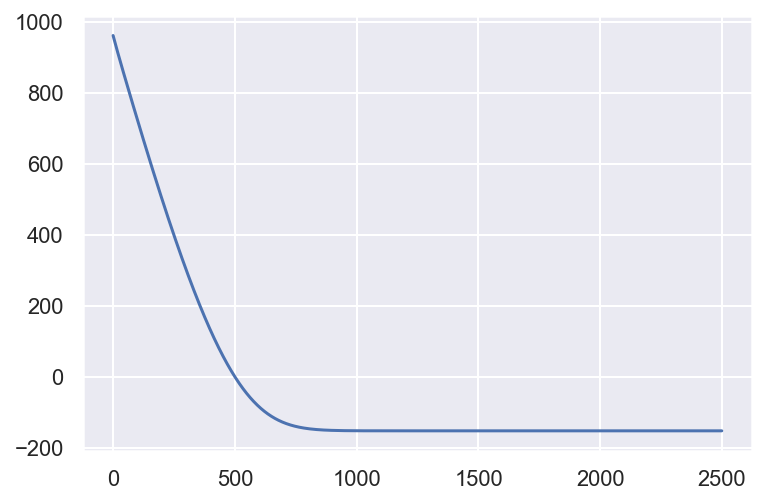

In [12]:
# initialize the inducing inputs
Xu = torch.arange(20.) / 4.0

# initialize the kernel and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-5)

# the way we setup inference is similar to above
optimizer = torch.optim.Adam(sgpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses);

inducing points:
[0.03217756 0.14740434 0.4138419  0.74363345 1.048308   1.1554842
 1.4786214  1.7912536  1.9827663  2.2814891  2.588945   2.8164217
 3.0900733  3.3992035  3.6858742  3.9619315  4.243296   4.579931
 4.8610287  5.0117803 ]


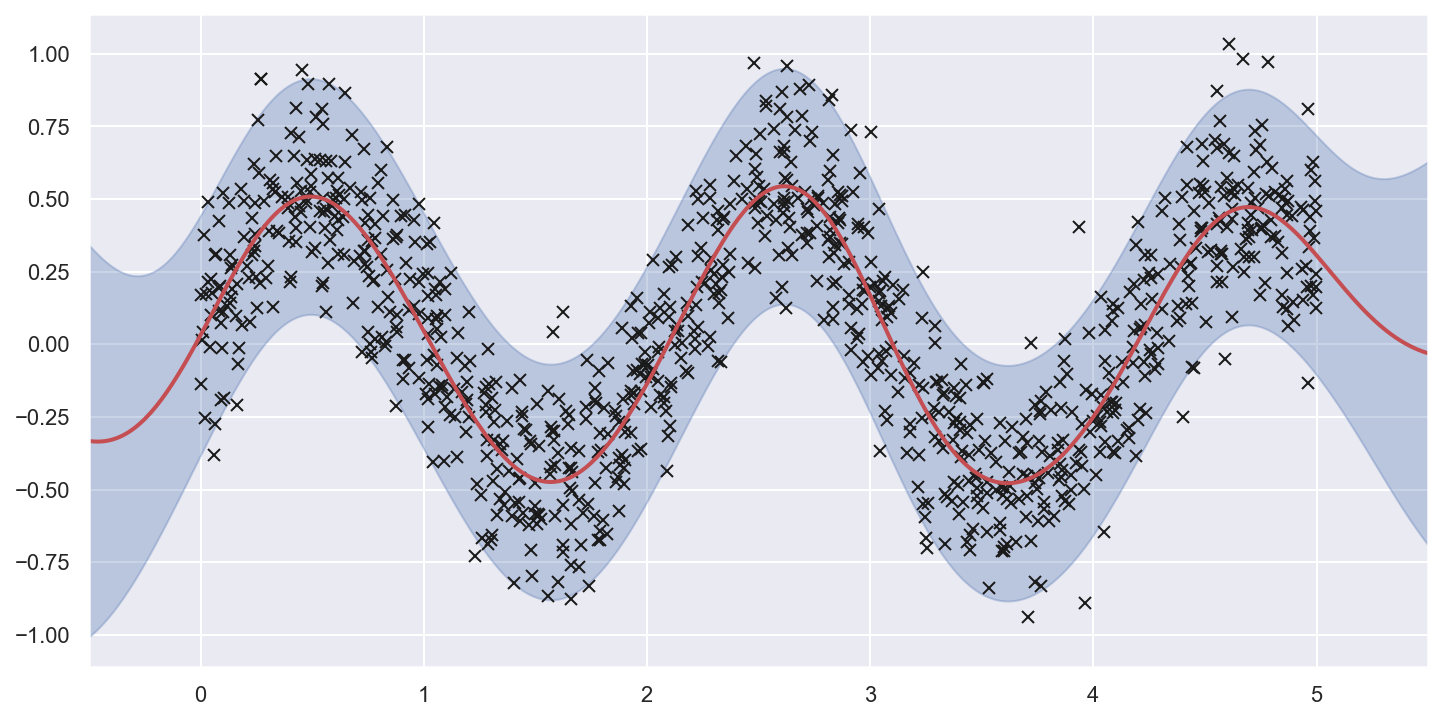

In [13]:
# let's look at the inducing points we've learned
print("inducing points:\n{}".format(sgpr.Xu.data.numpy()))
# and plot the predictions from the sparse GP
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)

## Spare regression with 'custom' likelihood

100%|██████████| 1500/1500 [00:08<00:00, 184.04it/s]


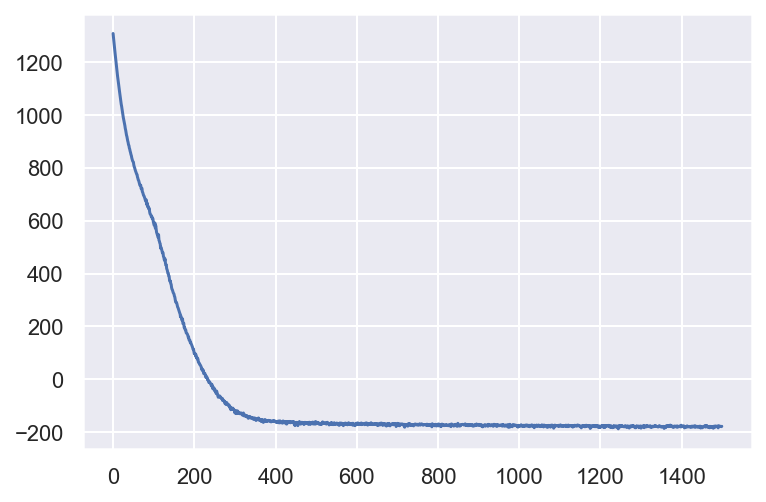

In [14]:
# from: gp.likelihoods.Gaussian
class Gaussian(gp.likelihoods.Likelihood):
    """
    Implementation of Gaussian likelihood, which is used for regression problems.
    Gaussian likelihood uses :class:`~pyro.distributions.Normal` distribution.
    :param torch.Tensor variance: A variance parameter, which plays the role of
        ``noise`` in regression problems.
    """
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = pyro.nn.module.PyroParam(variance, torch.distributions.constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        r"""
        Samples :math:`y` given :math:`f_{loc}`, :math:`f_{var}` according to
            .. math:: y \sim \mathbb{Normal}(f_{loc}, f_{var} + \epsilon),
        where :math:`\epsilon` is the ``variance`` parameter of this likelihood.
        :param torch.Tensor f_loc: Mean of latent function output.
        :param torch.Tensor f_var: Variance of latent function output.
        :param torch.Tensor y: Training output tensor.
        :returns: a tensor sampled from likelihood
        :rtype: torch.Tensor
        """
        y_var = f_var + self.variance
        
        # print(y)

        y_dist = dist.Normal(f_loc, y_var.sqrt())
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)


# initialize the inducing inputs
Xu = torch.arange(10.) / 2.0

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)

# likelihood = gp.likelihoods.Gaussian()
likelihood = Gaussian()
# turn on "whiten" flag for more stable optimization
vsgp = gp.models.VariationalSparseGP(X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True)

num_steps = 1500
optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(vsgp.model, vsgp.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

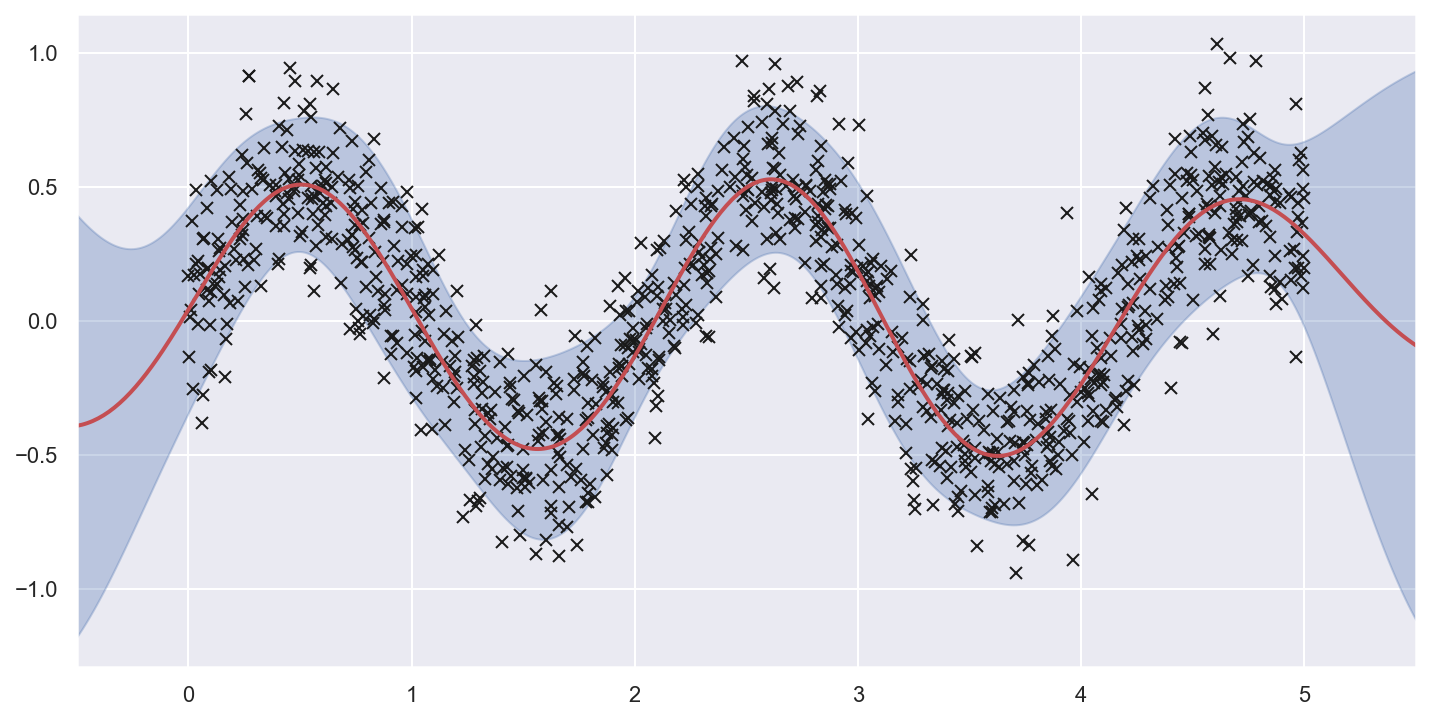

In [15]:
plot(model=vsgp, plot_observed_data=True, plot_predictions=True)

# Classification

## 'Regular' classification

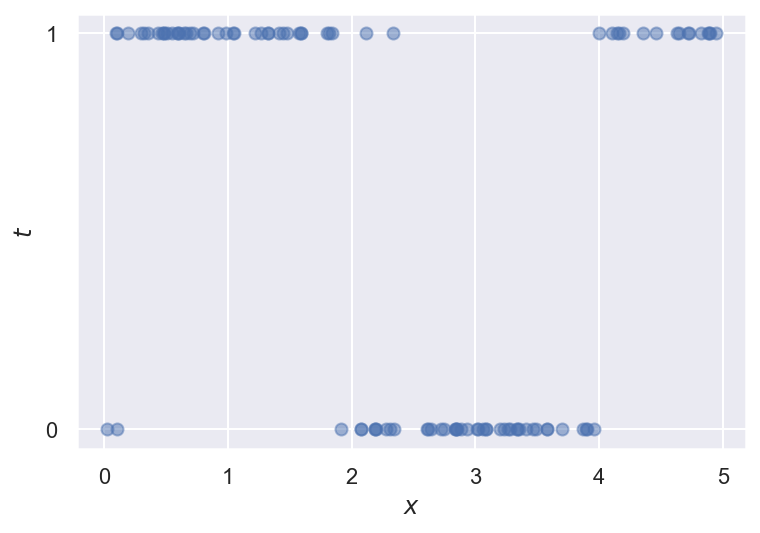

In [85]:
np.random.seed(0)

n = 100
x = np.random.uniform(0, 5, n)
x.sort()
y = np.zeros(x.shape)

f = np.sin(x * np.pi * 0.5) * 10
y[:] = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1]);

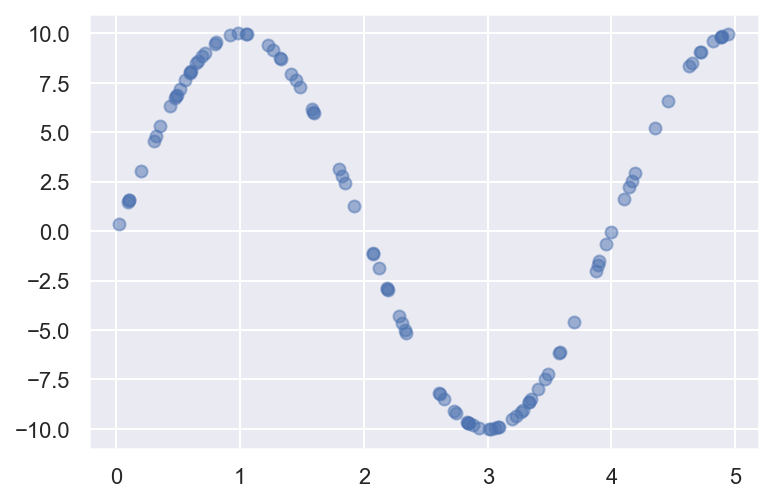

In [86]:
plt.scatter(x, f, alpha=0.5)

In [87]:
X = torch.from_numpy(x)
y = torch.from_numpy(y)

In [96]:
def res(f):
    return 1 / (1 + torch.exp(-f))

pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(20.),
                        lengthscale=torch.tensor(10.))

likelihood = gp.likelihoods.Binary(response_function=res)
gpc = gp.models.VariationalGP(X, y, kernel=kernel, likelihood=likelihood, whiten=True, jitter=2e-6, 
                             latent_shape=torch.Size([]))

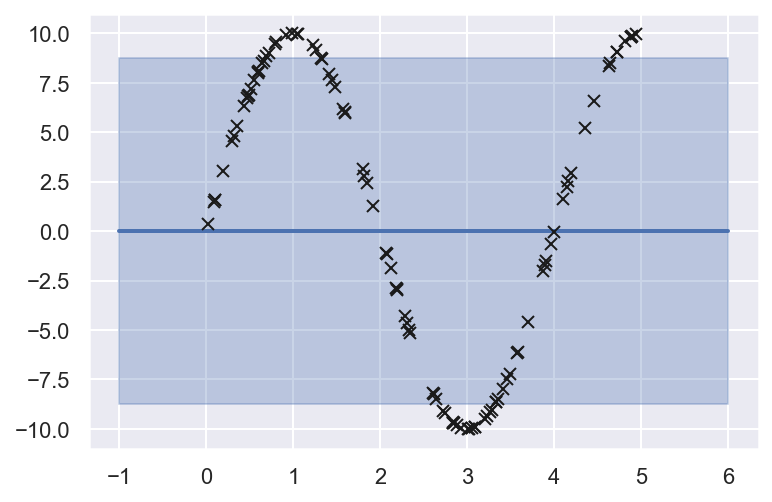

In [97]:
x_test = np.linspace(-1, 6, 100)
mean, cov = gpc(torch.from_numpy(x_test), full_cov=True)
sd = cov.diag().sqrt()
plt.plot(x_test, mean.detach().numpy(), 'C0', lw=2)
plt.fill_between(x_test,  # plot 0.95 CI
                 (mean - 1.96 * sd).detach().numpy(),
                 (mean + 1.96 * sd).detach().numpy(),
                 color='C0', alpha=0.3)
plt.plot(x, f, 'kx')

100%|██████████| 2000/2000 [00:09<00:00, 210.89it/s]


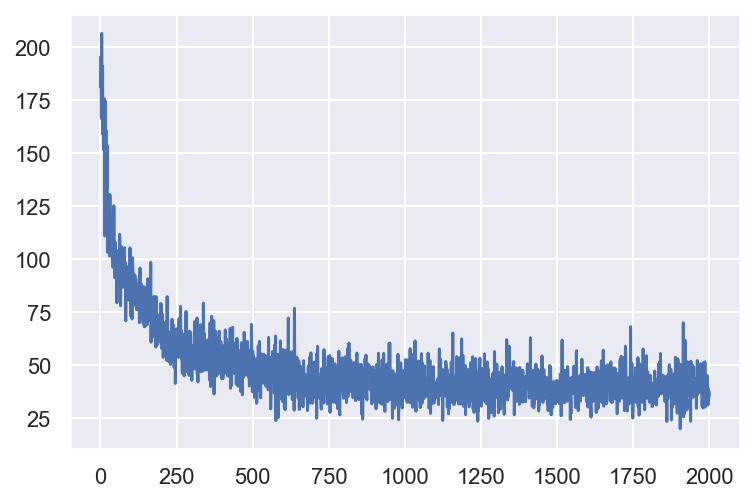

In [98]:
pyro.clear_param_store()
num_steps = 2000
optimizer = torch.optim.Adam(gpc.parameters(), lr=0.01)

losses = []
elbo = pyro.infer.Trace_ELBO()
loss_fn = elbo.differentiable_loss
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(model=gpc.model, guide=gpc.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses);

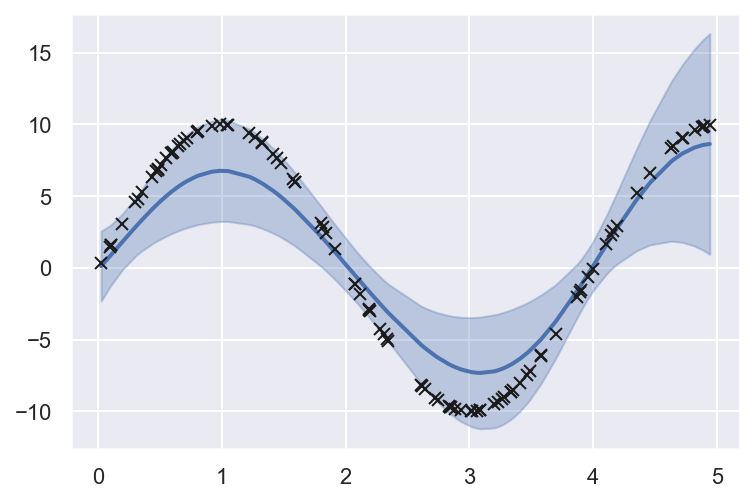

In [99]:
x_test = x # np.linspace(-1, 6, 100)
mean, cov = gpc(torch.from_numpy(x_test), full_cov=True)
sd = cov.diag().sqrt()
plt.plot(x_test, mean.detach().numpy(), 'C0', lw=2)
plt.fill_between(x_test,  # plot 0.95 CI
                 (mean - 1.96 * sd).detach().numpy(),
                 (mean + 1.96 * sd).detach().numpy(),
                 color='C0', alpha=0.3)
plt.plot(x, f, 'kx');

## Sparse classification

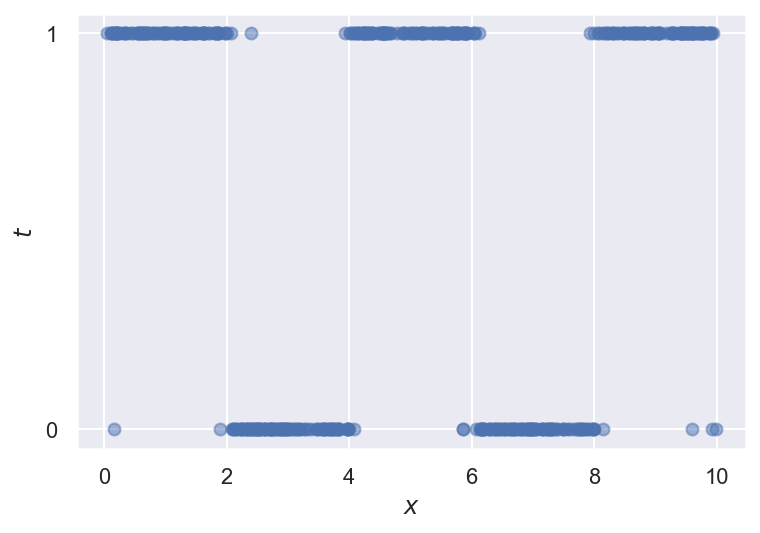

In [100]:
np.random.seed(0)

n = 500
x = np.random.uniform(0, 10, n)
x.sort()
y = np.zeros(x.shape)

f = np.sin(x * np.pi * 0.5) * 10
y[:] = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1]);

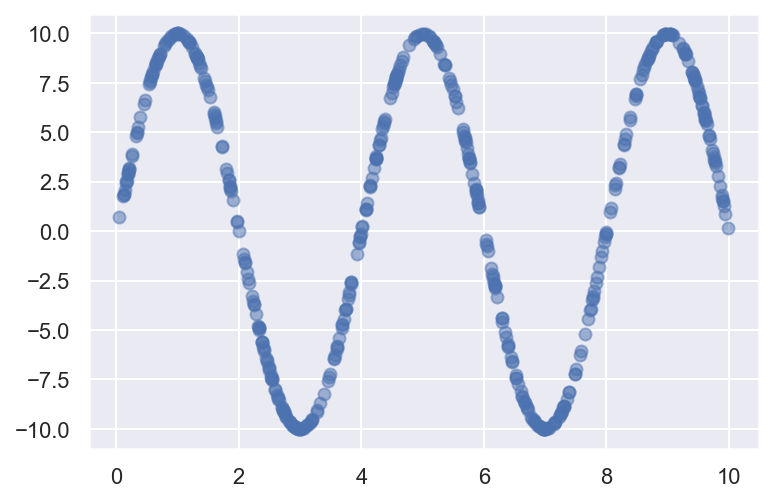

In [101]:
plt.scatter(x, f, alpha=0.5)

In [102]:
X = torch.from_numpy(x)
y = torch.from_numpy(y)

100%|██████████| 1500/1500 [00:08<00:00, 186.97it/s]


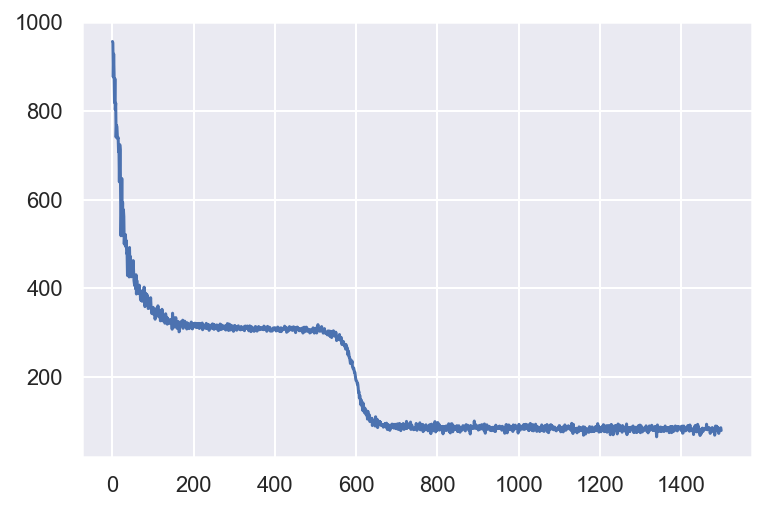

In [105]:
def res(f):
    return 1 / (1 + torch.exp(-f))

# initialize the inducing inputs
Xu = torch.from_numpy(np.linspace(0, 10, 10))

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, 
                        variance=torch.tensor(20.),
                        lengthscale=torch.tensor(10.))

likelihood = gp.likelihoods.Binary(response_function=res)

# turn on "whiten" flag for more stable optimization
cvsgp = gp.models.VariationalSparseGP(X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True)

num_steps = 1500
optimizer = torch.optim.Adam(cvsgp.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(cvsgp.model, cvsgp.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

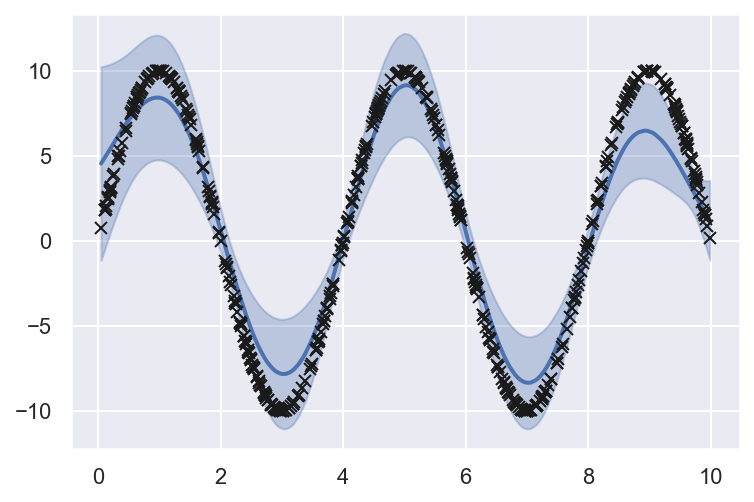

In [106]:
x_test = x # np.linspace(-1, 6, 100)
mean, cov = cvsgp(torch.from_numpy(x_test), full_cov=True)
sd = cov.diag().sqrt()
plt.plot(x_test, mean.detach().numpy(), 'C0', lw=2)
plt.fill_between(x_test,  # plot 0.95 CI
                 (mean - 1.96 * sd).detach().numpy(),
                 (mean + 1.96 * sd).detach().numpy(),
                 color='C0', alpha=0.3)
plt.plot(x, f, 'kx')

## Sparse classification using 'custom' probability function

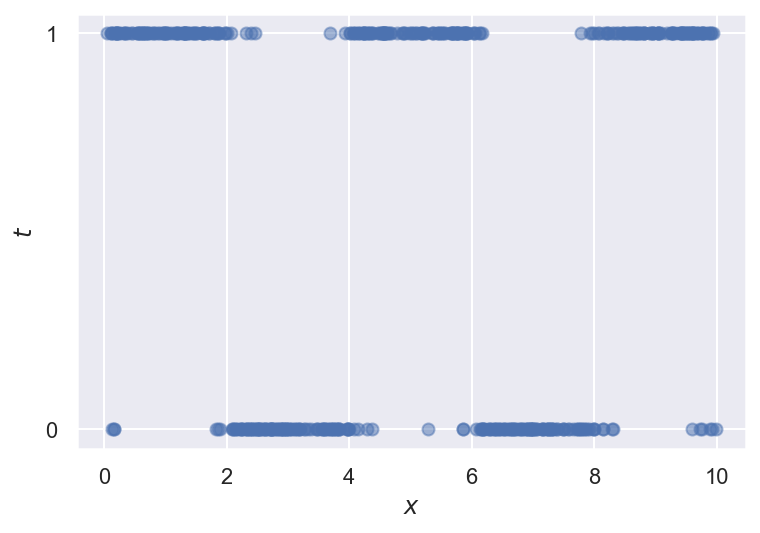

In [107]:
np.random.seed(0)

n = 500
x = np.random.uniform(0, 10, n)
x.sort()
y = np.zeros(x.shape)

f = np.sin(x * np.pi * 0.5) * 10
y[:] = scipy.stats.bernoulli.rvs(scipy.special.expit(0.5*f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1]);

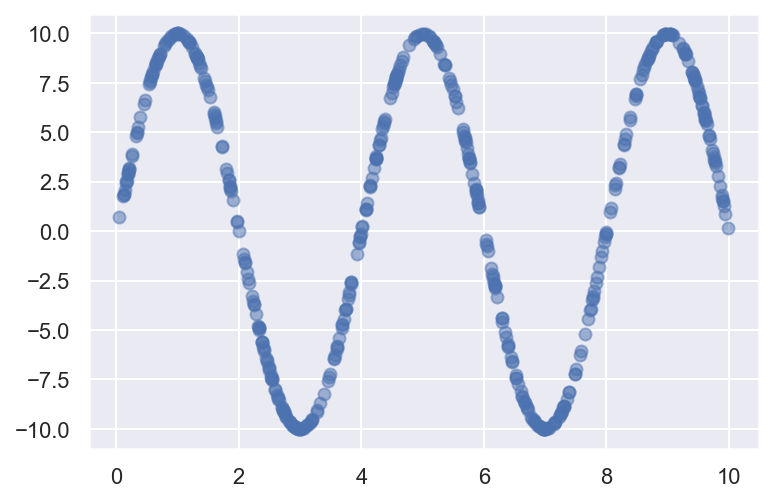

In [108]:
plt.scatter(x, f, alpha=0.5)

In [109]:
X = torch.from_numpy(x)
y = torch.from_numpy(y)

100%|██████████| 1500/1500 [00:08<00:00, 182.93it/s]


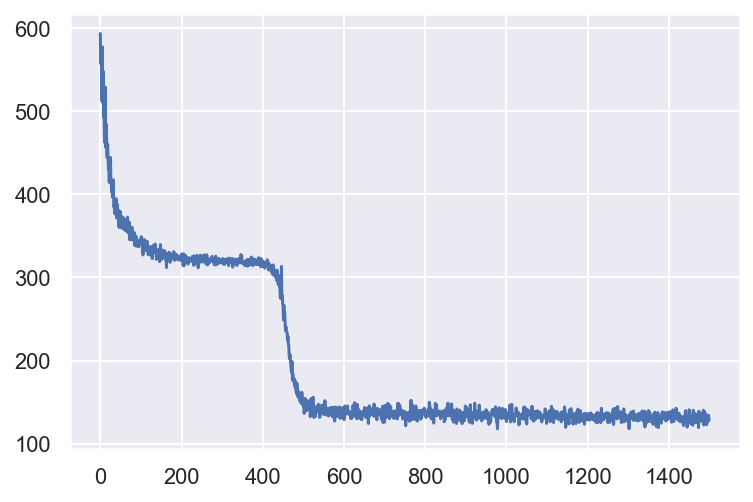

In [115]:
class Binary(pyro.contrib.gp.likelihoods.Likelihood):
    """
    Implementation of Binary likelihood, which is used for binary classification
    problems.
    Binary likelihood uses :class:`~pyro.distributions.Bernoulli` distribution,
    so the output of ``response_function`` should be in range :math:`(0,1)`. By
    default, we use `sigmoid` function.
    :param callable response_function: A mapping to correct domain for Binary
        likelihood.
    """
    def __init__(self, response_function=None):
        super().__init__()
        self.response_function = torch.sigmoid if response_function is None else response_function

    def forward(self, f_loc, f_var, y=None):
        r"""
        Samples :math:`y` given :math:`f_{loc}`, :math:`f_{var}` according to
            .. math:: f & \sim \mathbb{Normal}(f_{loc}, f_{var}),\\
                y & \sim \mathbb{Bernoulli}(f).
        .. note:: The log likelihood is estimated using Monte Carlo with 1 sample of
            :math:`f`.
        :param torch.Tensor f_loc: Mean of latent function output.
        :param torch.Tensor f_var: Variance of latent function output.
        :param torch.Tensor y: Training output tensor.
        :returns: a tensor sampled from likelihood
        :rtype: torch.Tensor
        """
        # calculates Monte Carlo estimate for E_q(f) [logp(y | f)]
        f = dist.Normal(f_loc, f_var.sqrt())()
        if self.response_function is torch.sigmoid:
            y_dist = dist.Bernoulli(logits=f)
        else:
            f_res = self.response_function(f)
            y_dist = dist.Bernoulli(f_res)
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)

def res(f):
    return 1 / (1 + torch.exp(-0.5*f))

# initialize the inducing inputs
Xu = torch.from_numpy(np.linspace(0, 10, 10))

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, 
                        variance=torch.tensor(20.),
                        lengthscale=torch.tensor(10.))

likelihood = Binary(response_function=res)

# turn on "whiten" flag for more stable optimization
cvsgp = gp.models.VariationalSparseGP(X, y, kernel, Xu=Xu, likelihood=likelihood, whiten=True)

num_steps = 1500
optimizer = torch.optim.Adam(cvsgp.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = loss_fn(cvsgp.model, cvsgp.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
#losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

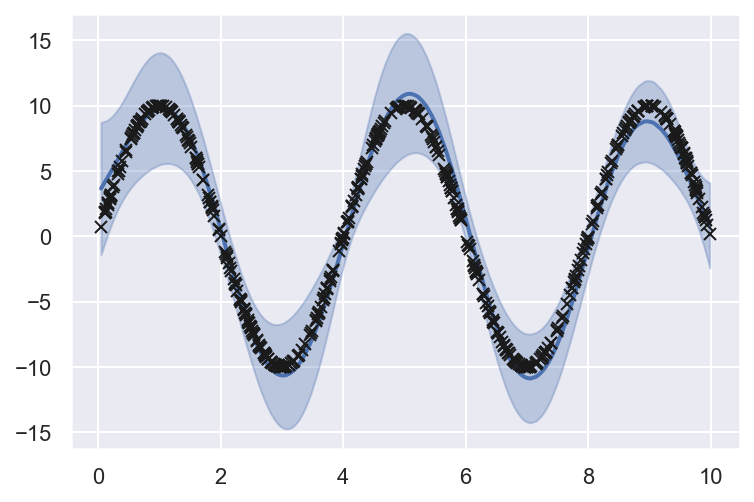

In [116]:
x_test = x # np.linspace(-1, 6, 100)
mean, cov = cvsgp(torch.from_numpy(x_test), full_cov=True)
sd = cov.diag().sqrt()
plt.plot(x_test, mean.detach().numpy(), 'C0', lw=2)
plt.fill_between(x_test,  # plot the two-sigma uncertainty about the mean
                 (mean - 2.0 * sd).detach().numpy(),
                 (mean + 2.0 * sd).detach().numpy(),
                 color='C0', alpha=0.3)
plt.plot(x, f, 'kx');